In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from mpl_toolkits.mplot3d import Axes3D

# Introduction

http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf

**Problem**: Only about 11% of customers at a Portuguese bank purchased long term deposits (between 2008 and 2013). How can the bank increase these numbers? 

This is a telemarketing campaign, so time is money! Therefore, what we want to maximize is the number of sales (during a fixed time period, eg. 40 hours), and I propose that targeting customers based only on their occupation will improve overall sales. Thus the key performance indicator (KPI) that we want to optimize is the time needed to ensure that at least one sale occurs. 

In [2]:
def to_int(is_true):
    if is_true == 'yes':
        return 1
    else:
        return 0

def weekday_to_int(day):
    dict = {"mon" : 0, "tue" : 1, "wed" : 2, "thu" : 3, "fri" : 4}
    return dict[day]

def month_to_int(month):
    dict = {"jan" : 0, 
            "feb" : 1, 
            "mar" : 2, 
            "apr" : 3, 
            "may" : 4, 
            "jun" : 5, 
            "jul" : 6, 
            "aug" : 7, 
            "sep" : 8, 
            "oct" : 9, 
            "nov" : 10, 
            "dec" : 11 }
    return dict[month]

# need to convert poutcome to a numeric variable
# currently consists of nonexistent, failure, success

def poutcome_to_int(x):
    dict = {"nonexistent" : np.nan, "failure" : 0, "success" : 1}
    return dict[x]
    
need_conversion = {"default" : to_int,
                   "housing" : to_int, 
                   "loan" : to_int,
                   "y" : to_int,
                   "day_of_week" : weekday_to_int,
                   "month" : month_to_int, 
                   "poutcome" : poutcome_to_int}

types = {"age": int, 
         "job" : "category",
         "marital" : "category",
         "education" : "category",
         "contact" : "category"}

df = pd.read_csv("bank-additional-full.csv", sep=';', converters=need_conversion, dtype=types)

age_brackets = ["19-28", "29-38", "39-47", "48-57", "58-67", "68-77", "78+"]
df["age_bracket"] = pd.cut(df.age, 4, labels=["1","2","3","4"])

## Variables

Input variables:
### bank client data
  1. age (numeric)
  2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  5. default: has credit in default? (categorical: "no","yes","unknown")
  6. housing: has housing loan? (categorical: "no","yes","unknown")
  7. loan: has personal loan? (categorical: "no","yes","unknown")


### related with the last contact of the current campaign
  8. contact: contact communication type (categorical: "cellular","telephone") 
  9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   
### other attributes
  12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14. previous: number of contacts performed before this campaign and for this client (numeric)
  15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### social and economic context attributes
  16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17. cons.price.idx: consumer price index - monthly indicator (numeric)     
  18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19. euribor3m: euribor 3 month rate - daily indicator (numeric)
  20. nr.employed: number of employees - quarterly indicator (numeric)
  
  
## notes

  Upon reading in the data, we transformed a few of the columns into a format more suitable for analysis, including:
  * default, housing, loan, poutcome: binary representation (0 or 1)
  * day_of_week: converted string abbreviation (mon, tue) to integers. starting with 0 for "mon"
  * month: similar to above, but with 0 representing "jan" and 11 for "dec" 
  
Certain variables only take on a small number of values, so we converted these fields into category variables:
  * job, marital, education and contact


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
age               41188 non-null int64
job               41188 non-null category
marital           41188 non-null category
education         41188 non-null category
default           41188 non-null int64
housing           41188 non-null int64
loan              41188 non-null int64
contact           41188 non-null category
month             41188 non-null int64
day_of_week       41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          5625 non-null float64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null int64
age_bracket       41188 non-null category
dtypes:

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_bracket
0,56,housemaid,married,basic.4y,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
1,57,services,married,high.school,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
2,37,services,married,high.school,0,1,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,1
3,40,admin.,married,basic.6y,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
4,56,services,married,high.school,0,0,1,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2


In [3]:
df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_bracket
count,41188.00000,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,...,41188.000000,41188.000000,5625.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,admin.,married,university.degree,NaN,NaN,NaN,cellular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
freq,NaN,10422,24928,12168,NaN,NaN,NaN,26144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19768
mean,40.02406,NaN,NaN,NaN,0.000073,0.523842,0.151695,NaN,5.607896,1.979581,...,962.475454,0.172963,0.244089,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,NaN
std,10.42125,NaN,NaN,NaN,0.008534,0.499437,0.358729,NaN,2.040998,1.411514,...,186.910907,0.494901,0.429584,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,NaN
min,17.00000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,2.000000,0.000000,...,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,NaN
25%,32.00000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,4.000000,1.000000,...,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,NaN
50%,38.00000,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,5.000000,2.000000,...,999.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,NaN
75%,47.00000,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,7.000000,3.000000,...,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,NaN


## Summary of Data

Just to get a brief overview of our data, here is what the typical customer looks like:
  * 40 years old
  * Married
  * Works in the admin field
  * Hold a university degree 
  * Has a housing loan with the bank offering the deposit
  * Reached via cellular phone

Stats on the current campaign:
  * Primarily conducted during the summer months, particularly April
  * Calls were made nearly uniform during the week (day)
  * Calls that resulted in no purchase lasted an average of 3.7 minutes and those that did result in a sale lasted an average of 9.2 minutes
  * Each customer was contacted an average of 2.5 times during this campaign

Stats on previous campaign(s):
  * After being contacted (for a previous campaign), an average of 962 days passed
  * During the last campaign, 1 in every 5.8 customers were contacted at least once
  * Every customer was contacted at least once during the current campaign
  * 24.4% of customers purchased a long-term deposit during the previous campaign
  * 86.3% of all customers were not contacted at all during the previous campaign
    * Which means only 13.6% of all customers were contacted at least once during both campaigns

The standard deviation of the social-economic variables are high (relative to it's mean). 

## Key Performance Indicator
For this experiment, the KPI that we wish to optimize is the average duration required to make one sale. My proposal is to  With this being said, it is also very important that all other variables remain the same (ex. total number of calls should not change dramatically). We do not wish to change the distribution of customer classes such as job or education, simply the selection process to identify candidates to call. 

In [56]:
job_sizes = df.groupby("job").size()
job_fracs = job_sizes / job_sizes.sum()
uniform_probs = 1 / len(job_fracs)
print("Uniform Probbility: {}".format(uniform_probs))
print("Observed Probabilities: \n{}".format(job_fracs))

Uniform Probbility: 0.08333333333333333
Observed Probabilities: 
job
admin.           0.253035
blue-collar      0.224677
entrepreneur     0.035350
housemaid        0.025736
management       0.070992
retired          0.041760
self-employed    0.034500
services         0.096363
student          0.021244
technician       0.163713
unemployed       0.024619
unknown          0.008012
dtype: float64


We need to adjust this probability matrix to increase the number of sales we make.

In [7]:
df.query("y == 0").describe()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,4126.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.000000,36548.0
mean,39.911185,0.000082,0.521752,0.152266,5.580853,1.974527,220.844807,2.633085,984.113878,0.132374,0.116093,0.248875,93.603757,-40.593097,3.811491,5176.166600,0.0
std,9.898132,0.009060,0.499533,0.359283,1.989920,1.416044,207.096293,2.873438,120.656868,0.409199,0.320375,1.482932,0.558993,4.391155,1.638187,64.571979,0.0
min,17.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.0
25%,32.000000,0.000000,0.000000,0.000000,4.000000,1.000000,95.000000,1.000000,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000,0.0
50%,38.000000,0.000000,1.000000,0.000000,5.000000,2.000000,163.500000,2.000000,999.000000,0.000000,0.000000,1.100000,93.918000,-41.800000,4.857000,5195.800000,0.0
75%,47.000000,0.000000,1.000000,0.000000,7.000000,3.000000,279.000000,3.000000,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.962000,5228.100000,0.0
max,95.000000,1.000000,1.000000,1.000000,11.000000,4.000000,4918.000000,56.000000,999.000000,7.000000,1.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,0.0


In [12]:
df.query("y == 1").describe()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4640.000000,4640.0,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,1499.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.0
mean,40.913147,0.0,0.540302,0.147198,5.820905,2.019397,553.191164,2.051724,792.035560,0.492672,0.596398,-1.233448,93.354386,-39.789784,2.123135,5095.115991,1.0
std,13.837476,0.0,0.498427,0.354342,2.395304,1.374815,401.171871,1.666245,403.407181,0.860344,0.490783,1.623626,0.676644,6.139668,1.742598,87.572641,0.0
min,17.000000,0.0,0.000000,0.000000,2.000000,0.000000,37.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,1.0
25%,31.000000,0.0,0.000000,0.000000,4.000000,1.000000,253.000000,1.000000,999.000000,0.000000,0.000000,-1.800000,92.893000,-46.200000,0.849000,5017.500000,1.0
50%,37.000000,0.0,1.000000,0.000000,6.000000,2.000000,449.000000,2.000000,999.000000,0.000000,1.000000,-1.800000,93.200000,-40.400000,1.266000,5099.100000,1.0
75%,50.000000,0.0,1.000000,0.000000,7.000000,3.000000,741.250000,2.000000,999.000000,1.000000,1.000000,-0.100000,93.918000,-36.100000,4.406000,5191.000000,1.0
max,98.000000,0.0,1.000000,1.000000,11.000000,4.000000,4199.000000,23.000000,999.000000,6.000000,1.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.0


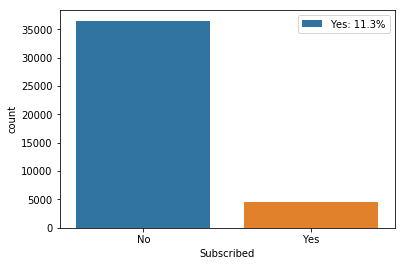

In [18]:
ax = sns.countplot(df.y)
plt.xticks([0,1],["No", "Yes"])
ax.set_xlabel("Subscribed")
plt.legend(["Yes: {}%".format(round(100*mu,1))])

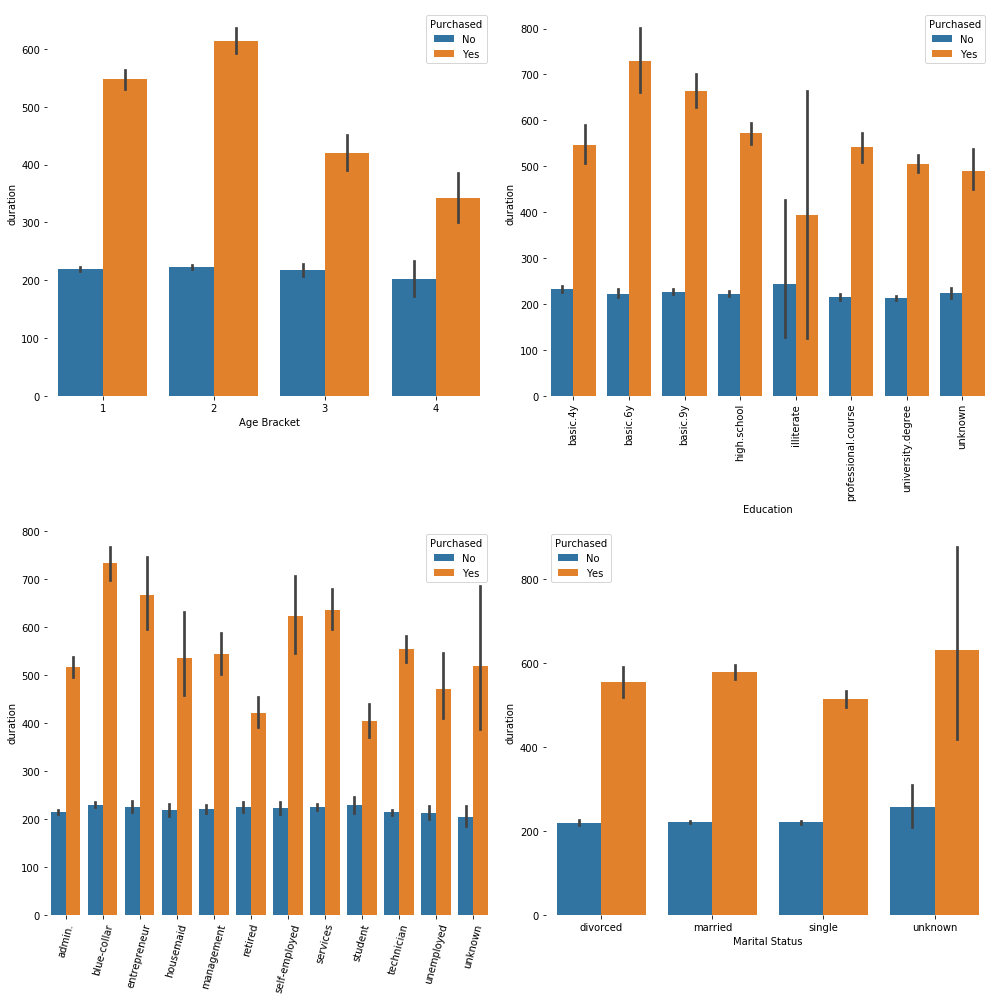

In [162]:
# lets put 4 pointplots on one figure
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(14)

sns.despine(fig=fig, left=True, bottom=True)
# pointplot of duration by age bracket
p1 = sns.barplot('age_bracket', "duration", hue="y", data=df, ax=axes[0,0])
axes[0,0].set_xlabel("Age Bracket")
p2 = sns.barplot('education', 'duration', hue='y', data=df, ax=axes[0,1])
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=90)
axes[0,1].set_xlabel("Education")
p3 = sns.barplot('job', 'duration', hue='y', data = df, ax=axes[1,0])
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=75)
axes[1,0].set_xlabel("")
p4 = sns.barplot('marital', 'duration', hue='y', data=df, ax=axes[1,1])
p4.set_xlabel("Marital Status")
fig.tight_layout()

# title
new_title = 'Purchased'
p1.legend_.set_title(new_title)
p2.legend_.set_title(new_title)
p3.legend_.set_title(new_title)
p4.legend_.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(p1.legend_.texts, new_labels): t.set_text(l)
for t, l in zip(p2.legend_.texts, new_labels): t.set_text(l)
for t, l in zip(p3.legend_.texts, new_labels): t.set_text(l)
for t, l in zip(p4.legend_.texts, new_labels): t.set_text(l)   
fig.show()

From these plots we can see that there is little variance in duration of call when no purchase was made, however there does appear to be more variation in duration where a purchase was made. This behavior appears to be the most significant among occupations.

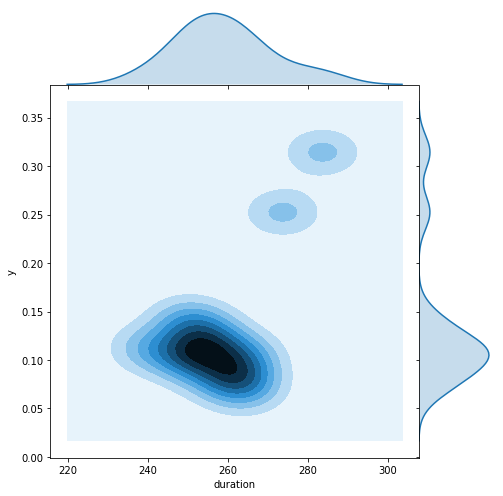

In [38]:
x = df.groupby("job")["duration", "y"].mean()
sns.jointplot(x="duration", y="y", data=x, kind="kde", height=7, space=0);

In [74]:
avg_durations = (1 / x.y) * x.duration
avg_durations.sort_index(inplace=True)
stats = pd.concat([avg_durations, df.groupby("job").size(), x.y, job_fracs], axis=1)
stats.columns = ["duration_required", "count", "rate", "observed_prob"]

In [75]:
stats

,duration_required,count,rate,observed_prob
job,,,,
admin.,1960.385355,10422,0.129726,0.253035
blue-collar,3837.108150,9254,0.068943,0.224677
entrepreneur,3091.274194,1456,0.085165,0.035350
housemaid,2504.547170,1060,0.100000,0.025736
management,2291.579268,2924,0.112175,0.070992
retired,1084.758065,1720,0.252326,0.041760
self-employed,2519.100671,1421,0.104856,0.034500
services,3175.176471,3969,0.081381,0.096363
student,902.629091,875,0.314286,0.021244


So we definitely want to minimize how many customers we call who work in the blue-collar and services fields, and call more students and retired customers. We can just simply swap the probabilities of those groups (blue-collar observed probability and student, services and retired).

In [276]:
max_duration = 2000
sales = pd.DataFrame(columns=df.job.unique())
for title in df.job.unique():
    temp = []
    for d in range(0,max_duration):
        x = df.query("job == '{}' & duration <= {}".format(title, d))
        temp.append(x.y.sum() / len(x))
    sales[title] = temp

In [76]:
fig = plt.figure(figsize=(12,10))
xrange = range(0,max_duration)
sns.lineplot(x=xrange, y=sales["blue-collar"], label = "blue-collar")
sns.lineplot(x=xrange, y=sales["housemaid"], label = "housemaid")
sns.lineplot(x=xrange, y = sales["services"], label = "services")
sns.lineplot(x=xrange, y = sales["admin."], label = "admin")
sns.lineplot(x=xrange, y = sales["technician"], label = "technician")
sns.lineplot(x=xrange, y = sales["unemployed"], label = "unemployed")
sns.lineplot(x=xrange, y = sales["self-employed"], label = "self-employed")
sns.lineplot(x=xrange, y = sales["unknown"], label = "unknown")
sns.lineplot(x=xrange, y = sales["entrepreneur"], label = "entrepreneur")
sns.lineplot(x=xrange, y = sales["student"], label = "student")
plt.xlabel("Duration")
plt.ylabel("Purchase Rate")
plt.title("Purchase Rate v. Duration")
sns.despine()

NameError: name 'max_duration' is not defined

<Figure size 864x720 with 0 Axes>

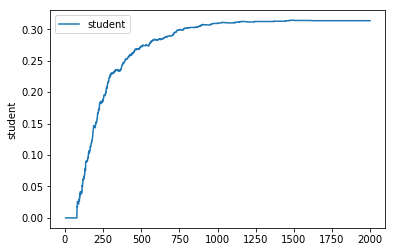

In [294]:
sns.lineplot(x=xrange, y = sales["student"], label = "student")

In [359]:
df.corr()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.001891,-0.001414,-0.007198,0.077265,-0.018486,-0.000866,0.004594,-0.034369,0.024365,0.070651,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
default,0.001891,1.000000,-0.003256,-0.003609,0.010003,-0.005923,-0.005101,-0.003803,0.001668,0.002766,-0.007577,0.004445,-0.003141,0.004492,0.005274,0.005941,-0.003041
housing,-0.001414,-0.003256,1.000000,0.056651,0.033252,-0.009280,-0.006804,-0.010800,-0.010719,0.020446,0.003700,-0.059862,-0.081920,-0.034496,-0.058913,-0.045046,0.011743
loan,-0.007198,-0.003609,0.056651,1.000000,-0.001696,0.001850,0.000121,0.005294,-0.000086,-0.002143,-0.001113,0.001193,-0.005944,-0.013673,-0.000487,0.004205,-0.004466
month,0.077265,0.010003,0.033252,-0.001696,1.000000,-0.006959,-0.019302,-0.030635,-0.079556,0.063754,0.118006,0.058874,-0.150350,0.264227,0.163411,0.132697,0.037187
day_of_week,-0.018486,-0.005923,-0.009280,0.001850,-0.006959,1.000000,0.010549,0.015098,0.006765,0.004013,-0.028250,-0.004401,-0.004586,-0.000099,-0.005552,-0.000734,0.010051
duration,-0.000866,-0.005101,-0.006804,0.000121,-0.019302,0.010549,1.000000,-0.071699,-0.047577,0.020640,0.130641,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.003803,-0.010800,0.005294,-0.030635,0.015098,-0.071699,1.000000,0.052584,-0.079141,-0.058456,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,0.001668,-0.010719,-0.000086,-0.079556,0.006765,-0.047577,0.052584,1.000000,-0.587514,-0.936492,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.002766,0.020446,-0.002143,0.063754,0.004013,0.020640,-0.079141,-0.587514,1.000000,0.269468,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181


Not surprisingly, current campaign purchase rates are correlated with previous outcomes as well as phone call duration, however it is interesting to see that purchases are also correlated with socio-economic metrics such as the Euribor rate, employee variation rate and number of employees. The latter two metrics may only be relevant to the bank at hand, and if so it appears that the more stable your work environment is, the more conversions you get. 
The Euro Interbank Offered Rate (Euribor) is a daily reference rate, published by the European Money Markets Institute, based on the averaged interest rates at which Euribor banks offer to lend unsecured funds to other banks in the euro wholesale money market (or interbank market).

# Proposal
It requires significantly more time to ensure at least one sale when calling customers who work in the blue-collar and services fields. My proposal is to simply change the probabilities of calling customers based on their occupation. Because full timestamps are not available, the original method needs to be conducted for a period of 2 weeks before the proposed experiment is performed. 

## Experimental Design

In order to mitigate any effects due to time, we will split the sales associates into 2 groups (of equal sizes). It is important that the customer list be split so that the distribution of classes (occupations) remains constant and that the total time duration is the same for both groups (40 hours a week). The list of customers will also be split in half. The experiment will be conducted over 2 weeks and after each week the groups will flip (double blind study, the participants must not know).

### Groups
  1. A: Continue calling customers as before (no changes in probabilities, control group)
  2. B: Use the original probabilities to select customers to call, however swap that probability of blue-collar employees with that of students, and the probability of services with that of retired customers. 
  
### Evaluation
Our alternative hypothesis is that calling less blue-collar/services customers and more students/retired customers will result in an increase in total sales per time period. This KPI is easily calculated, and a T-test will be conducted on the two groups in order to determine if the change in the two sales are statistically significant. If our hypothesis holds, we recommend implementing this change in customer selection.

### Furthermore
Here are a few more suggestions:
  1. Record full timestamps of calls
  2. Record the sales associate ID
  3. Pay attention to the outcome of the previous campaign and adjust the gap between calls accordingly.
  4. The student population requires much less time in order to get a purchase, so these customers should be contacted more often than other employees. However the size of this group is relatively small (875) compared to others (blue-collar consists of 9,254 customers), therefore a simple swap to another occupation is limited.
  
  